In [75]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sktime.forecasting.model_selection import temporal_train_test_split
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from prophet import Prophet
from util_prophet import *

In [24]:
y_train = pd.read_csv('train_msft.csv')
y_valid = pd.read_csv('val_msft.csv')
data = pd.read_csv('msft.csv')

In [25]:
y_train['date'] = pd.to_datetime(y_train['date'])
y_train.set_index('date', inplace = True )
y_valid['date'] = pd.to_datetime(y_valid['date'])
y_valid.set_index('date', inplace = True )
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace = True )

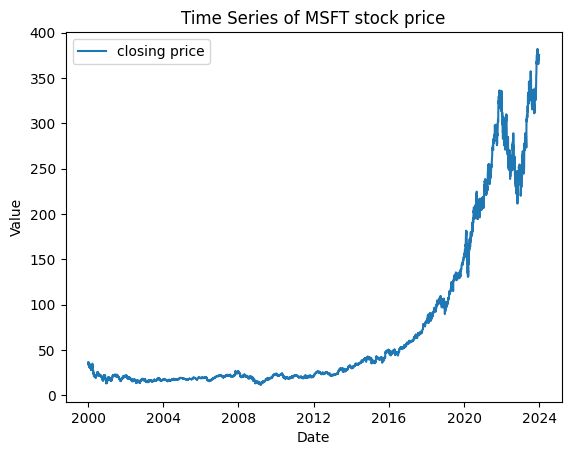

In [26]:
plt.plot(data['adj_close'], label='closing price')
plt.title('Time Series of MSFT stock price')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

In [27]:
from statsmodels.tsa.stattools import kpss, adfuller

In [28]:
def adf_test(time_series, alpha = 0.05):
    result = adfuller(time_series, autolag='AIC')
    adf_output = {
        'ADF Test Statistic': result[0],
        'p-value': result[1],
        'Lags Used': result[2],
        'Number of Observations': result[3],
        'Critical Values': result[4],
        'IC Best': result[5],
        'Stationarity': result[1] <= alpha
    }
    return adf_output

def kpss_test(time_series, trend = 'c',alpha = 0.05):
    statistic, p_value, lags, critical_values = kpss(time_series, regression=trend, nlags='auto')
    kpss_output = {
        'KPSS Test Statistic': statistic,
        'p-value': p_value,
        'Lags Used': lags,
        'Critical Values': critical_values,
        'Stationarity': p_value >= alpha
    }
    return kpss_output

In [29]:
adf_test(y_train['adj_close'])

{'ADF Test Statistic': -2.2711142172683143,
 'p-value': 0.1814534884515746,
 'Lags Used': 21,
 'Number of Observations': 3600,
 'Critical Values': {'1%': -3.432167769140796,
  '5%': -2.8623431886668382,
  '10%': -2.5671975500771604},
 'IC Best': 3660.55452466087,
 'Stationarity': False}

In [30]:
kpss_test(y_train['adj_close'])

{'KPSS Test Statistic': 2.781717635360367,
 'p-value': 0.01,
 'Lags Used': 38,
 'Critical Values': {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739},
 'Stationarity': False}

In [31]:
#try seasonal differencing with respect to a year
diff1 = y_train[['adj_close']].diff(255).dropna()
adf_test(diff1['adj_close'])

{'ADF Test Statistic': -4.903415168877724,
 'p-value': 3.434446234246713e-05,
 'Lags Used': 1,
 'Number of Observations': 3365,
 'Critical Values': {'1%': -3.4322948129049493,
  '5%': -2.8623993051360332,
  '10%': -2.5672274248944094},
 'IC Best': 5284.076368768391,
 'Stationarity': True}

In [32]:
kpss_test(diff1['adj_close'])

{'KPSS Test Statistic': 1.6448339168450385,
 'p-value': 0.01,
 'Lags Used': 37,
 'Critical Values': {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739},
 'Stationarity': False}

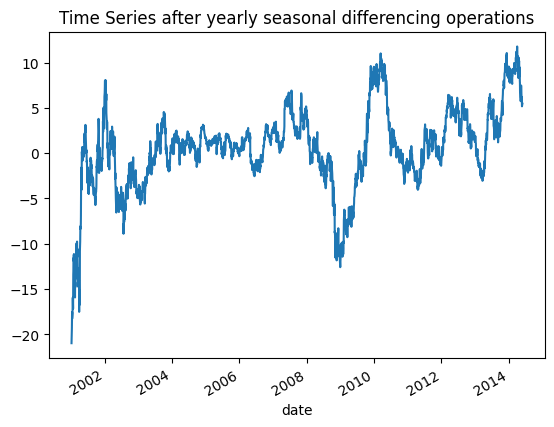

In [33]:
diff1["adj_close"].plot(title=f'Time Series after yearly seasonal differencing operations')
plt.show()

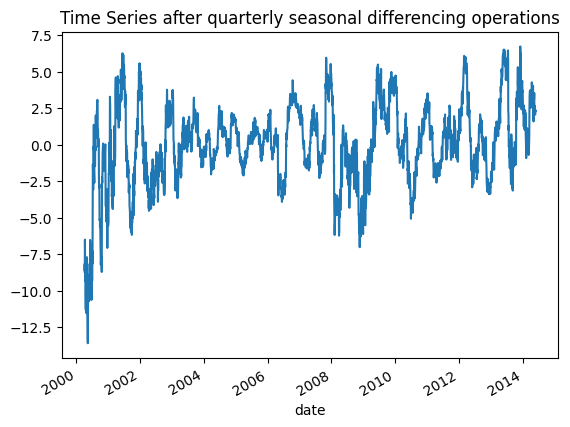

In [34]:
diff2 = y_train[['adj_close']].diff(64).dropna()
diff2["adj_close"].plot(title=f'Time Series after quarterly seasonal differencing operations')
plt.show()
#rationale: Microsoft’s stock price movements are influenced by its quarterly earnings reports

In [35]:
#non-seasonal differencing to stablize the mean
diff_nonseasonal = diff2[['adj_close']].diff(1).dropna()
adf_test(diff_nonseasonal['adj_close'])

{'ADF Test Statistic': -28.440997284674467,
 'p-value': 0.0,
 'Lags Used': 4,
 'Number of Observations': 3552,
 'Critical Values': {'1%': -3.4321923513750416,
  '5%': -2.8623540470659,
  '10%': -2.5672033307494573},
 'IC Best': 5854.247699611666,
 'Stationarity': True}

In [36]:
kpss_test(diff_nonseasonal['adj_close'])

{'KPSS Test Statistic': 0.02635273784380183,
 'p-value': 0.1,
 'Lags Used': 10,
 'Critical Values': {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739},
 'Stationarity': True}

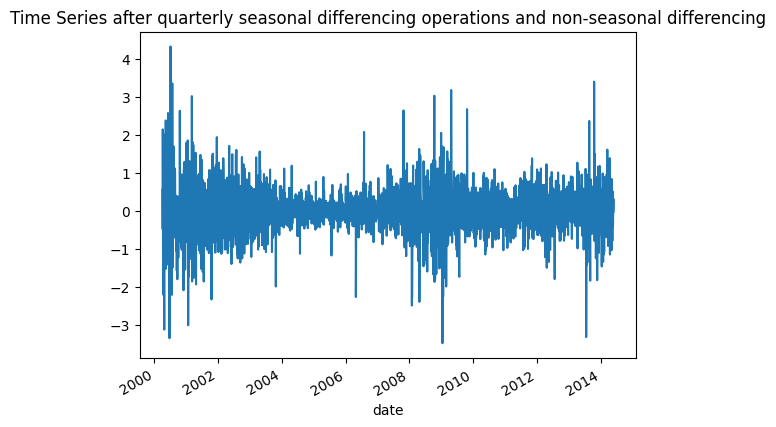

In [37]:
diff_nonseasonal["adj_close"].plot(title=f'Time Series after quarterly seasonal differencing operations and non-seasonal differencing')
plt.show()

### auto-arima

In [18]:
import warnings
warnings.filterwarnings('ignore')

import pmdarima as pm

In [21]:
#auto arima (without seasonality)
autoarima_model = pm.auto_arima(y_train, d=1, D=1, m=64, seasonal=False, stepwise=True)

In [22]:
autoarima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3622
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1926.622
Date:                Thu, 02 May 2024   AIC                           3859.244
Time:                        21:18:57   BIC                           3877.827
Sample:                             0   HQIC                          3865.864
                               - 3622                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5897      0.128      4.599      0.000       0.338       0.841
ma.L1         -0.6335      0.122     -5.184      0.000      -0.873      -0.394
sigma2         0.1697      0.001    116.852      0.000       0.167       0.173
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):             26596.00
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               0.43   Skew:                            -0.69
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [42]:
autosarima_model = pm.auto_arima(y_train[-500:], d=1, D=1, m=64, seasonal=True, stepwise=True)

In [43]:
autosarima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  500
Model:             SARIMAX(0, 1, 0)x(1, 1, 0, 64)   Log Likelihood                -315.511
Date:                            Thu, 02 May 2024   AIC                            635.021
Time:                                    22:30:23   BIC                            643.172
Sample:                                         0   HQIC                           638.238
                                            - 500                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L64      -0.4445      0.026    -17.163      0.000      -0.495      -0.394
sigma2         0.2418      0.008     31.106      0.000       0.227       0.257
===================================================================================
Ljung-Box (L1) (Q):                   0.51   Jarque-Bera (JB):               881.22
Prob(Q):                              0.47   Prob(JB):                         0.00
Heteroskedasticity (H):               2.45   Skew:                            -0.40
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [65]:
### residual for auto seasonal arima

<Axes: xlabel='date'>

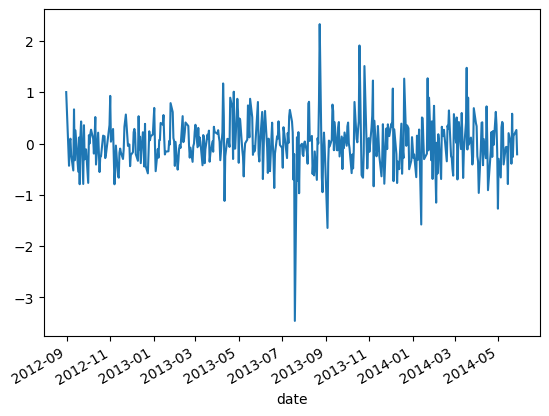

In [58]:
resid = autosarima_model.resid()
resid = resid[65:]
resid.plot()

<Axes: >

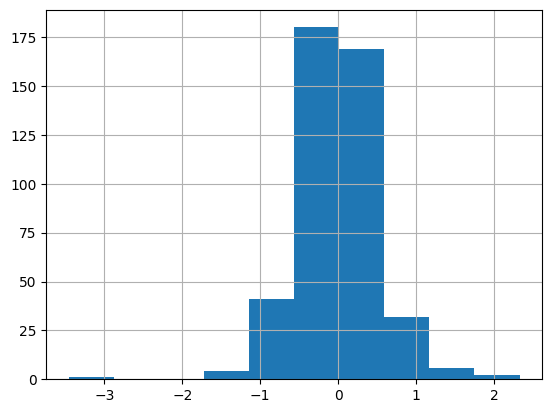

In [59]:
resid.hist()

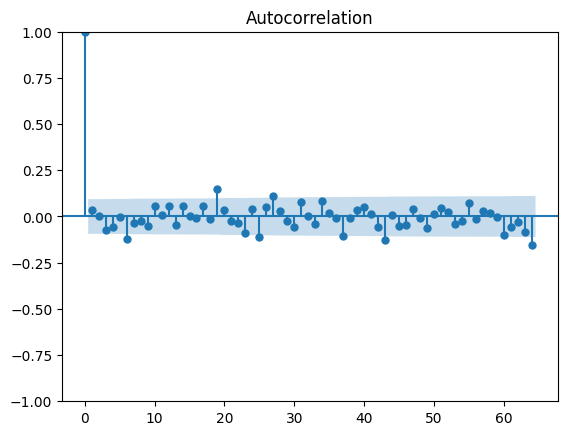

In [60]:
plot_acf(resid, lags=64)
plt.show()

In [64]:
sm.stats.acorr_ljungbox(resid, lags=[12], return_df=True, boxpierce=True)

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
12,15.684236,0.20613,15.381198,0.221249


In [66]:
### residual analysis for non-seasonal arima

<Axes: xlabel='date'>

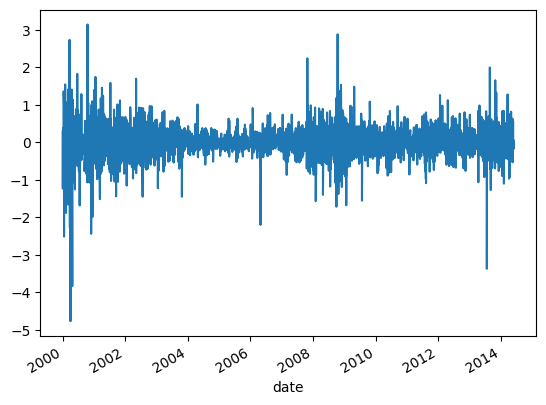

In [68]:
resid = autoarima_model.resid()
resid = resid[1:]
resid.plot()

<Axes: >

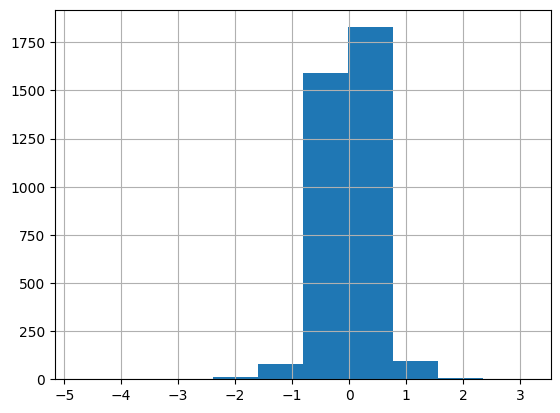

In [69]:
resid.hist()

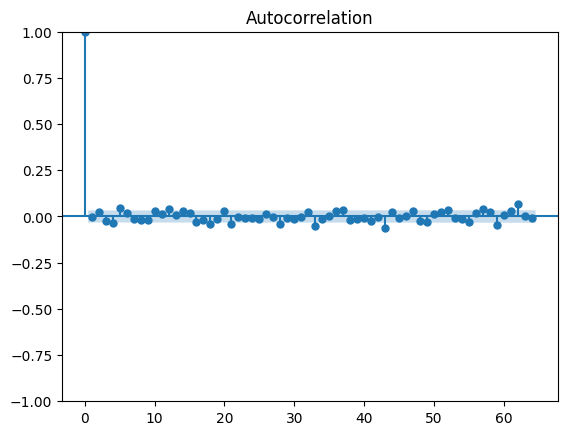

In [70]:
plot_acf(resid, lags=64)
plt.show()

In [71]:
sm.stats.acorr_ljungbox(resid, lags=[12], return_df=True, boxpierce=True)
# show strong autocorrelation in early lags, indicating importance for accounting seasonality in the model

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
12,30.951645,0.002004,30.8736,0.002059


In [44]:
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error,mean_absolute_scaled_error
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

### error metrics for auto arima with seasonality parameter

In [45]:
y_pred = autosarima_model.predict(n_periods=len(y_valid))

In [46]:
mae_auto = mean_absolute_error(y_valid,y_pred)

In [47]:
mse_auto = mean_squared_error(y_valid, y_pred)

In [48]:
mape_auto = mean_absolute_percentage_error(y_valid, y_pred)*100

In [49]:
smape_auto = mean_absolute_percentage_error(y_valid, y_pred, symmetric = True)*100

In [50]:
print(f"MAE: {mae_auto}")
print(f"MSE: {mse_auto}")
print(f"MAPE: {mape_auto}")
print(f"sMAPE: {smape_auto}")

MAE: 11.443280748041966
MSE: 298.67128455248707
MAPE: 14.320958724919644
sMAPE: 16.2675373109983


### error metrics for auto arima without seasonality parameter

In [51]:
y_pred = autoarima_model.predict(n_periods=len(y_valid))

In [52]:
mae_auto2 = mean_absolute_error(y_valid,y_pred)

In [53]:
mse_auto2 = mean_squared_error(y_valid, y_pred)

In [54]:
mape_auto2 = mean_absolute_percentage_error(y_valid, y_pred)*100

In [55]:
smape_auto2 = mean_absolute_percentage_error(y_valid, y_pred, symmetric = True)*100

In [56]:
print(f"MAE: {mae_auto2}")
print(f"MSE: {mse_auto2}")
print(f"MAPE: {mape_auto2}")
print(f"sMAPE: {smape_auto2}")

MAE: 27.50134062244967
MSE: 1278.0397032903677
MAPE: 37.21910464749972
sMAPE: 49.76928495137029


### prophet

In [73]:
y_train_p = y_train.copy()
y_train_p['y'] = y_train_p['adj_close']
y_train_p['ds'] = y_train.index

In [77]:
model_1 = Prophet()
model_1.fit(y_train_p)

22:49:44 - cmdstanpy - INFO - Chain [1] start processing
22:49:45 - cmdstanpy - INFO - Chain [1] done processing


In [106]:
if isinstance(y_valid.index, pd.DatetimeIndex):
    validation_dates = pd.DataFrame({'ds': y_valid.index})
else:

    validation_dates = pd.DataFrame({'ds': pd.to_datetime(y_valid['ds'])})


all_dates = pd.concat([
    model_1.history[['ds']],  
    validation_dates 
]).drop_duplicates().reset_index(drop=True)

future = pd.DataFrame({'ds': all_dates['ds']})

In [111]:
forecast = model_1.predict(future)

training_actuals = model_1.history[['ds', 'y']]
results = pd.merge(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], training_actuals, on='ds', how='right')

results['residuals'] = results['y'] - results['yhat'] #training residual

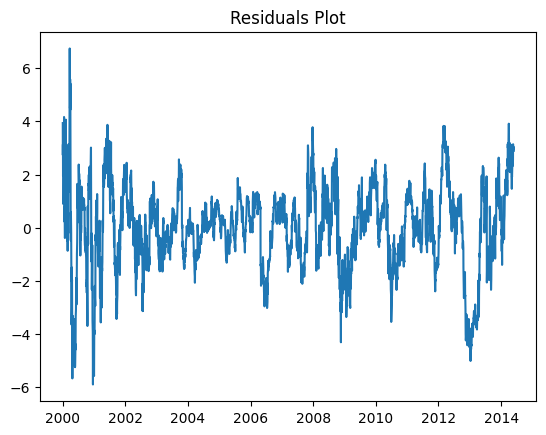

In [113]:
plt.plot(results['ds'], results['residuals'], label='Residuals')
plt.title('Residuals Plot')
plt.show()

<Axes: >

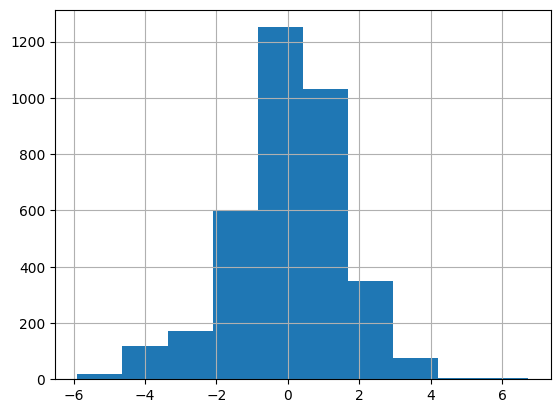

In [114]:
results['residuals'].hist()

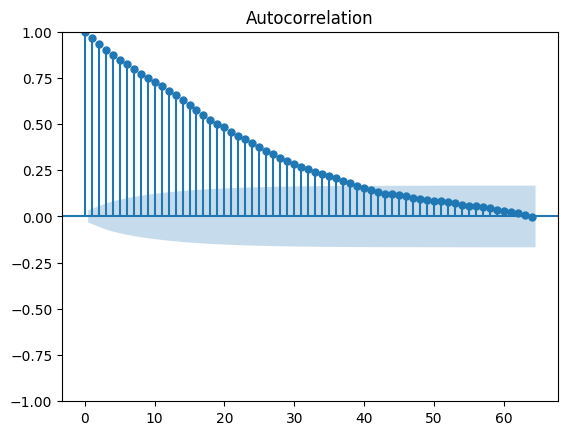

In [115]:
plot_acf(results['residuals'], lags=64)
plt.show()

In [116]:
sm.stats.acorr_ljungbox(results['residuals'], lags=[12], return_df=True, boxpierce=True)

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
12,29189.811716,0.0,29127.25436,0.0


In [117]:
y_valid

,adj_close
date,
2014-05-29,34.518057
2014-05-30,35.031463
2014-06-02,34.903112
2014-06-03,34.475273
2014-06-04,34.500943
...,...
2019-03-08,105.538319
2019-03-11,107.753945
2019-03-12,108.508404


In [118]:
mae_prophet1 = mean_absolute_error(y_valid['adj_close'],forecast['yhat'][-len(y_valid):])

In [119]:
mse_prophet1 = mean_squared_error(y_valid['adj_close'],forecast['yhat'][-len(y_valid):])

In [120]:
mape_prophet1 = mean_absolute_percentage_error(y_valid['adj_close'],forecast['yhat'][-len(y_valid):])*100

In [121]:
smape_prophet1 = mean_absolute_percentage_error(y_valid['adj_close'],forecast['yhat'][-len(y_valid):], symmetric = True)*100

In [123]:
print(f"MAE: {mae_prophet1}")
print(f"MSE: {mse_prophet1}")
print(f"MAPE: {mape_prophet1}")
print(f"sMAPE: {smape_prophet1}")

MAE: 19.879928661035613
MSE: 697.8018251688126
MAPE: 26.69331717672117
sMAPE: 32.65696577529834
